In [1]:
import pandas as pd
import numpy as np

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.gaussian_process.kernels import RBF
import sys
sys.path.append("/home/leon/projects/gaussian_process/")
from gaussian_process_visualisation import visualise_1D_gaussian_process, visualise_2D_gaussian_process
from gaussian_process_hyperparameter_tuning import optimise_hyperparameters


In [2]:
path = "/home/leon/learning/gaussian-processes/bank/bank-full.csv"
data = pd.read_csv(path, sep=";")
one_hot_encode = ["job", "marital", "education", "contact", "poutcome", "month"]
binary = ["default", "housing", "loan", "y"]

In [3]:
enc = OneHotEncoder()

In [4]:
def yesNoBinary(column):
    return(pd.DataFrame([1 if value == "yes" else 0 for value in column], columns = [column.name]))

In [5]:
one_hot = pd.DataFrame(enc.fit_transform(data[one_hot_encode]).toarray(), columns=enc.get_feature_names_out(one_hot_encode))

In [6]:
data2 = pd.concat([one_hot] + [ yesNoBinary(data[col]) if col in binary else data[col] for col in data.columns ], 1).drop(one_hot_encode, 1)

/tmp/ipykernel_13506/194164172.py:1: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  data2 = pd.concat([one_hot] + [ yesNoBinary(data[col]) if col in binary else data[col] for col in data.columns ], 1).drop(one_hot_encode, 1)
/tmp/ipykernel_13506/194164172.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  data2 = pd.concat([one_hot] + [ yesNoBinary(data[col]) if col in binary else data[col] for col in data.columns ], 1).drop(one_hot_encode, 1)


In [7]:
hyperparameters = [
    [("max_features", ['auto', 'sqrt', 'log2']),
    ("criterion", ['gini','entropy'])],
    
    [("n_estimators", np.arange(1, 1000, 1)),
    ("max_depth", np.arange(1, 1000, 1)),
    ("min_samples_split", np.arange(2, 100, 1)),
    ("min_samples_leaf", np.arange(1, 50, 1)),
    ("min_impurity_decrease", np.arange(0.0, 1.0, 0.01))]
]

In [8]:
hyperparameters = [
    [("weights", ['uniform', 'distance'])],
    [("n_neighbors", np.arange(4, 100, 1)),
     ("leaf_size", np.arange(5, 100, 5))]
]

In [9]:
X = np.random.random((1000, 2))
y = np.array([int(x* 5) for x in np.random.random((1000))])
for i in range(10):
    for j in range(100):
        distances = np.hypot(*(X - X[j,:]).T)
        closest = np.argpartition(distances, 5)[:20]
        labels = y[closest]
        unique, counts = np.unique(labels, return_counts=True)
        label = unique[counts.argmax()]
        y = np.array([y[ii] if ii not in closest else label for ii in range(1000)])
        
        
np.unique(y, return_counts=True)

(array([0, 1, 2, 3, 4]), array([236, 126, 352, 153, 133]))

In [10]:
kernel = RBF(1.0)
(best_configurations, best_scores), gp_datas = optimise_hyperparameters(KNeighborsClassifier, hyperparameters, 500, X, y, 10, kernel=kernel)

/home/leon/miniconda3/envs/dev/lib/python3.10/site-packages/sklearn/gaussian_process/_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/home/leon/miniconda3/envs/dev/lib/python3.10/site-packages/sklearn/gaussian_process/_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/home/leon/miniconda3/envs/dev/lib/python3.10/site-packages/sklearn/gaussian_process/_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown 

In [15]:
from sklearn.model_selection import cross_val_score

knn_best = KNeighborsClassifier(**best_configurations[0])
score_best = np.mean(cross_val_score(knn_best, X, y, cv=5))

knn_default = KNeighborsClassifier()
score_default = np.mean(cross_val_score(knn_default, X, y, cv=5))

In [16]:
score_best

0.8640000000000001

In [17]:
score_default

0.841

In [19]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.utils.extmath import cartesian
from sklearn.gaussian_process.kernels import RBF, ConstantKernel

gaussian = GaussianProcessRegressor(kernel=kernel)
#gaussian.fit(result['uniform'][0], result['uniform'][0].dot(np.array([1.0, 3.0]))/500)
gaussian.fit(gp_datas['uniform'][0], gp_datas['uniform'][1])

GaussianProcessRegressor(kernel=RBF(length_scale=1))

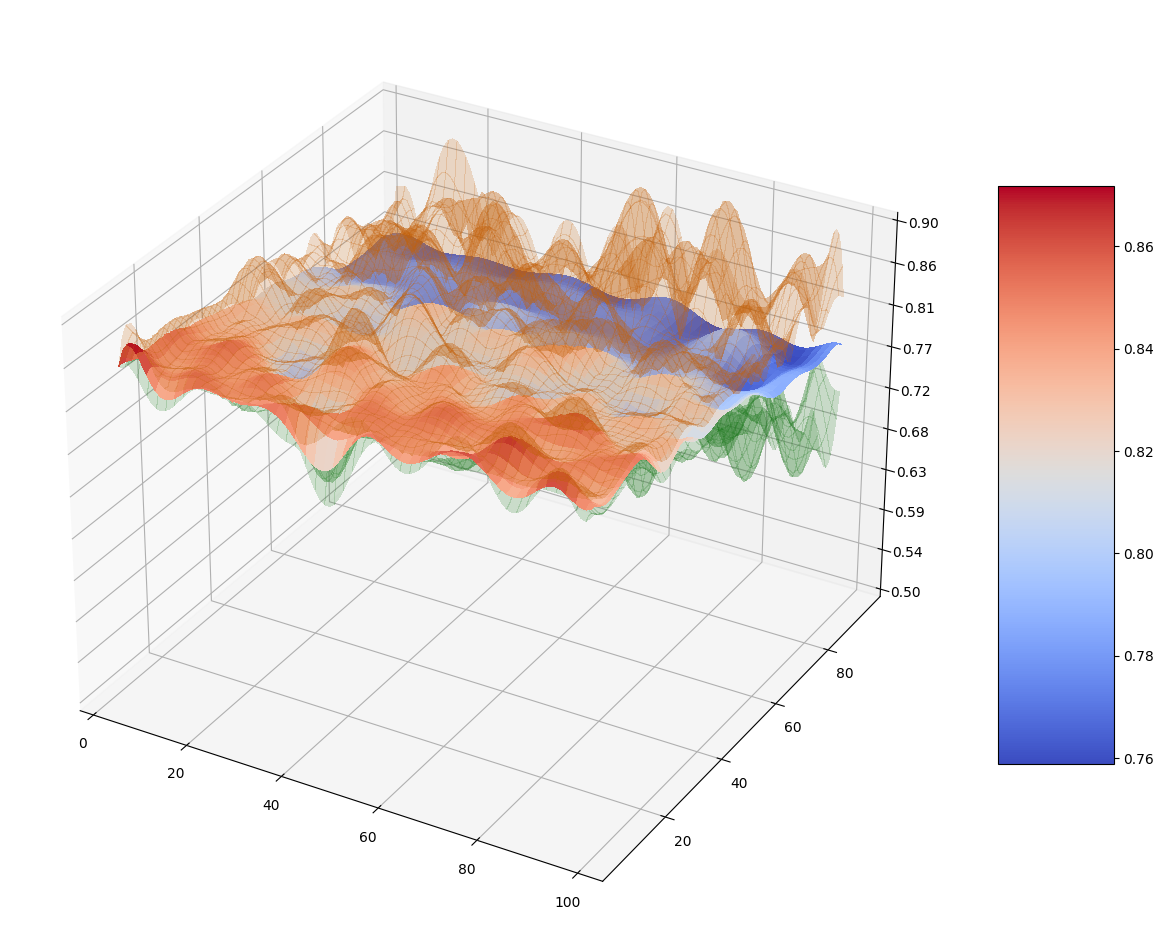

In [20]:
visualise_2D_gaussian_process(gaussian, np.arange(4, 100, 1), np.arange(5, 100, 5), np.arange(0.5, 1, 0.1))